In [34]:
"""
This file is implementing the vanilla LSTM.
The test set used are the 31 days of December of a single time-serie of the 261 time-series with measurements of the full year 2017.
Missing days are estimated.
Naive basemodels that are used are the mean forecast and the MAPE-minimization.
Evaluation metrics used: MSE, RMSE, NRMSE, MAE
####################################################

calculate the MSE on the total test set and for each day of the week.
Should normalize history and temperature with min max
Rest: weekday, time, holiday use one hot encoder
Stack different LSTM blocks --> hidden nodes serve as inputs for next LSTM's
Use finally a fully connected layer to generate an output
Use different learning rules: adam!!, stochastic gradient descent, Adagrad, Adadelta and RMSProp
Adam has parameters: learning rate, momentum and decay
play with mini batches

Inputs:
1. history ok
2. temp ok
3. day week ok
4. time ok
5. holiday
6. (previous week future lag)
7. previous week error history lag --> how good are you following previous week
just the difference between the values
8. previous weeks load at the same moment in time and the temperatures of these days
"""


"\nThis file is implementing the vanilla LSTM.\nThe test set used are the 31 days of December of a single time-serie of the 261 time-series with measurements of the full year 2017.\nMissing days are estimated.\nNaive basemodels that are used are the mean forecast and the MAPE-minimization.\nEvaluation metrics used: MSE, RMSE, NRMSE, MAE\n####################################################\n\ncalculate the MSE on the total test set and for each day of the week.\nShould normalize history and temperature with min max\nRest: weekday, time, holiday use one hot encoder\nStack different LSTM blocks --> hidden nodes serve as inputs for next LSTM's\nUse finally a fully connected layer to generate an output\nUse different learning rules: adam!!, stochastic gradient descent, Adagrad, Adadelta and RMSProp\nAdam has parameters: learning rate, momentum and decay\nplay with mini batches\n\nInputs:\n1. history ok\n2. temp ok\n3. day week ok\n4. time ok\n5. holiday\n6. (previous week future lag)\n7. p

In [35]:
from forecasting_functions import *

In [36]:
# importing the data
Stijn = True
fullYearpath = None
av_temperaturepath = None
if Stijn:
    fullYearpath = "D:\Onedrive\Leuven\Final project\data\Forecasting_writtendata\FullYear.csv"
    av_temperaturepath = "D:\Onedrive\Leuven\Final project\data\weather-avg.csv"
else:
    raise Exception("Put some paths here.")
fullYeardata = pd.read_csv(fullYearpath,index_col= "date",parse_dates= True)
av_temperature = pd.read_csv(av_temperaturepath,index_col='meter_id')
av_temperature = av_temperature.transpose()
av_temperature.index = pd.to_datetime(av_temperature.index)

In [37]:
time_serie1 = time_serie(fullYeardata[fullYeardata.columns[1]], av_temperature)
setting1 = forecast_setting(units_LSTM = 20, layers_LSTM = 2, units_DENSE = 75, layers_DENSE= 1, patience = 5, shuffle = False, lag_value = 48, nb_epoch = 100, batch_size_para = 16, repeat = 10, activation = 'relu', learning_rate = 0.001, dropout_LSTM = 0.0, recurrent_dropout_LSTM = 0.0, kernel_regularizer_LSTM = None, recurrent_regularizer_LSTM = None, bais_regularizer_LSTM = None, activity_regularizer_LSTM = None, dropout_DENSE = 0, kernel_regularizer_DENSE = None, bais_regularizer_DENSE = None, activity_regularizer_DENSE = None)
# setting1 = forecast_setting(units_LSTM = 10, layers_LSTM=1, units_DENSE = 5, layers_DENSE= 1, patience = 5, shuffle = False, lag_value = 3, nb_epoch = 150, batch_size_para = 32, repeat = 10, activation = 'tanh', kernel_regularizer_DENSE= 0.01)

In [38]:
print(time_serie1.training_true.shape)

(16032,)


Shape X original: (15984, 48, 59).
(14548, 48, 59)
(14548, 1)
(1436, 48, 59)
(1436, 1)


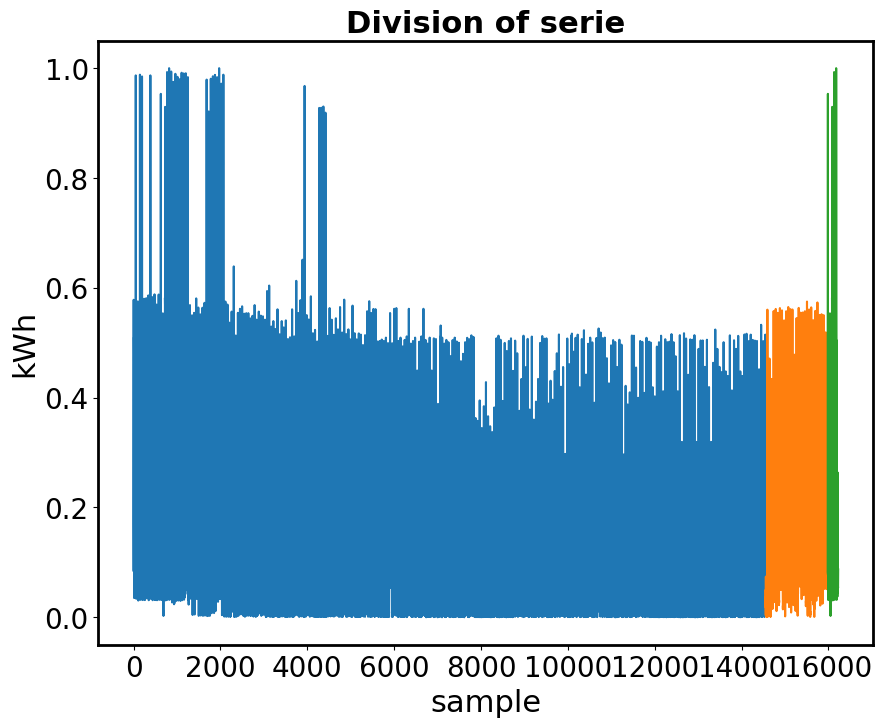

In [39]:
X,y = input_output_LSTM(time_serie1.training_true, time_serie1.temperature_norm, setting1.lag_value)
print("Shape X original: %s."%(X.shape,))
((X,y),(X_val,y_val)) = generate_training_validation_division(X,y,1,0.91018)

print(X.shape)
print(y.shape)
print(X_val.shape)
print(y_val.shape)

axis1 = figure_layout(titel="Division of serie", xlabel="sample", ylabel="kWh")
axis1.plot(np.arange(1,len(y)+1),y.squeeze())
axis1.plot(np.arange(len(y)+1, len(y)+len(y_val)+1),y_val.squeeze())
axis1.plot(np.arange(len(y)+len(y_val)+1,len(y)+len(y_val)+1+len(time_serie1.test)), time_serie1.test)

# path = "Vanilla_LSTM_figures/"
# fname = path+"division_data" + ".png"
# plt.savefig(fname, dpi=300, facecolor='w', edgecolor='w', orientation='portrait', format=None,
#             transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)


In [43]:
X.shape

(14548, 48, 59)

In [42]:
print("start")
np.save("X_48.npy",X)
print("busy")
np.save("y_48.npy",y)
print("finished")

start
busy
finished


In [44]:
X_new = np.load("X_48.npy")
X_new.shape

(14548, 48, 59)

In [31]:
trained_model, history = build_model_stateless2(setting1, X,y, X_val, y_val)
# trained_model, history = build_model_stateless1(setting1, X,y, X_val, y_val, reset_after_epoch= True)

Train on 568 samples, validate on 56 samples
Epoch 1/100
568/568 [==============================] - 4s 7ms/step - loss: 0.0296 - val_loss: 0.0152

In [32]:
trained_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 48, 20)            6400      
_________________________________________________________________
lstm_4 (LSTM)                (None, 48, 20)            3280      
_________________________________________________________________
flatten_2 (Flatten)          (None, 960)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 960)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 75)                72075     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [33]:
all_predictions, all_references = test_set_prediction(trained_model, setting1, time_serie1, time_serie1.test, X, X_val, True, False)


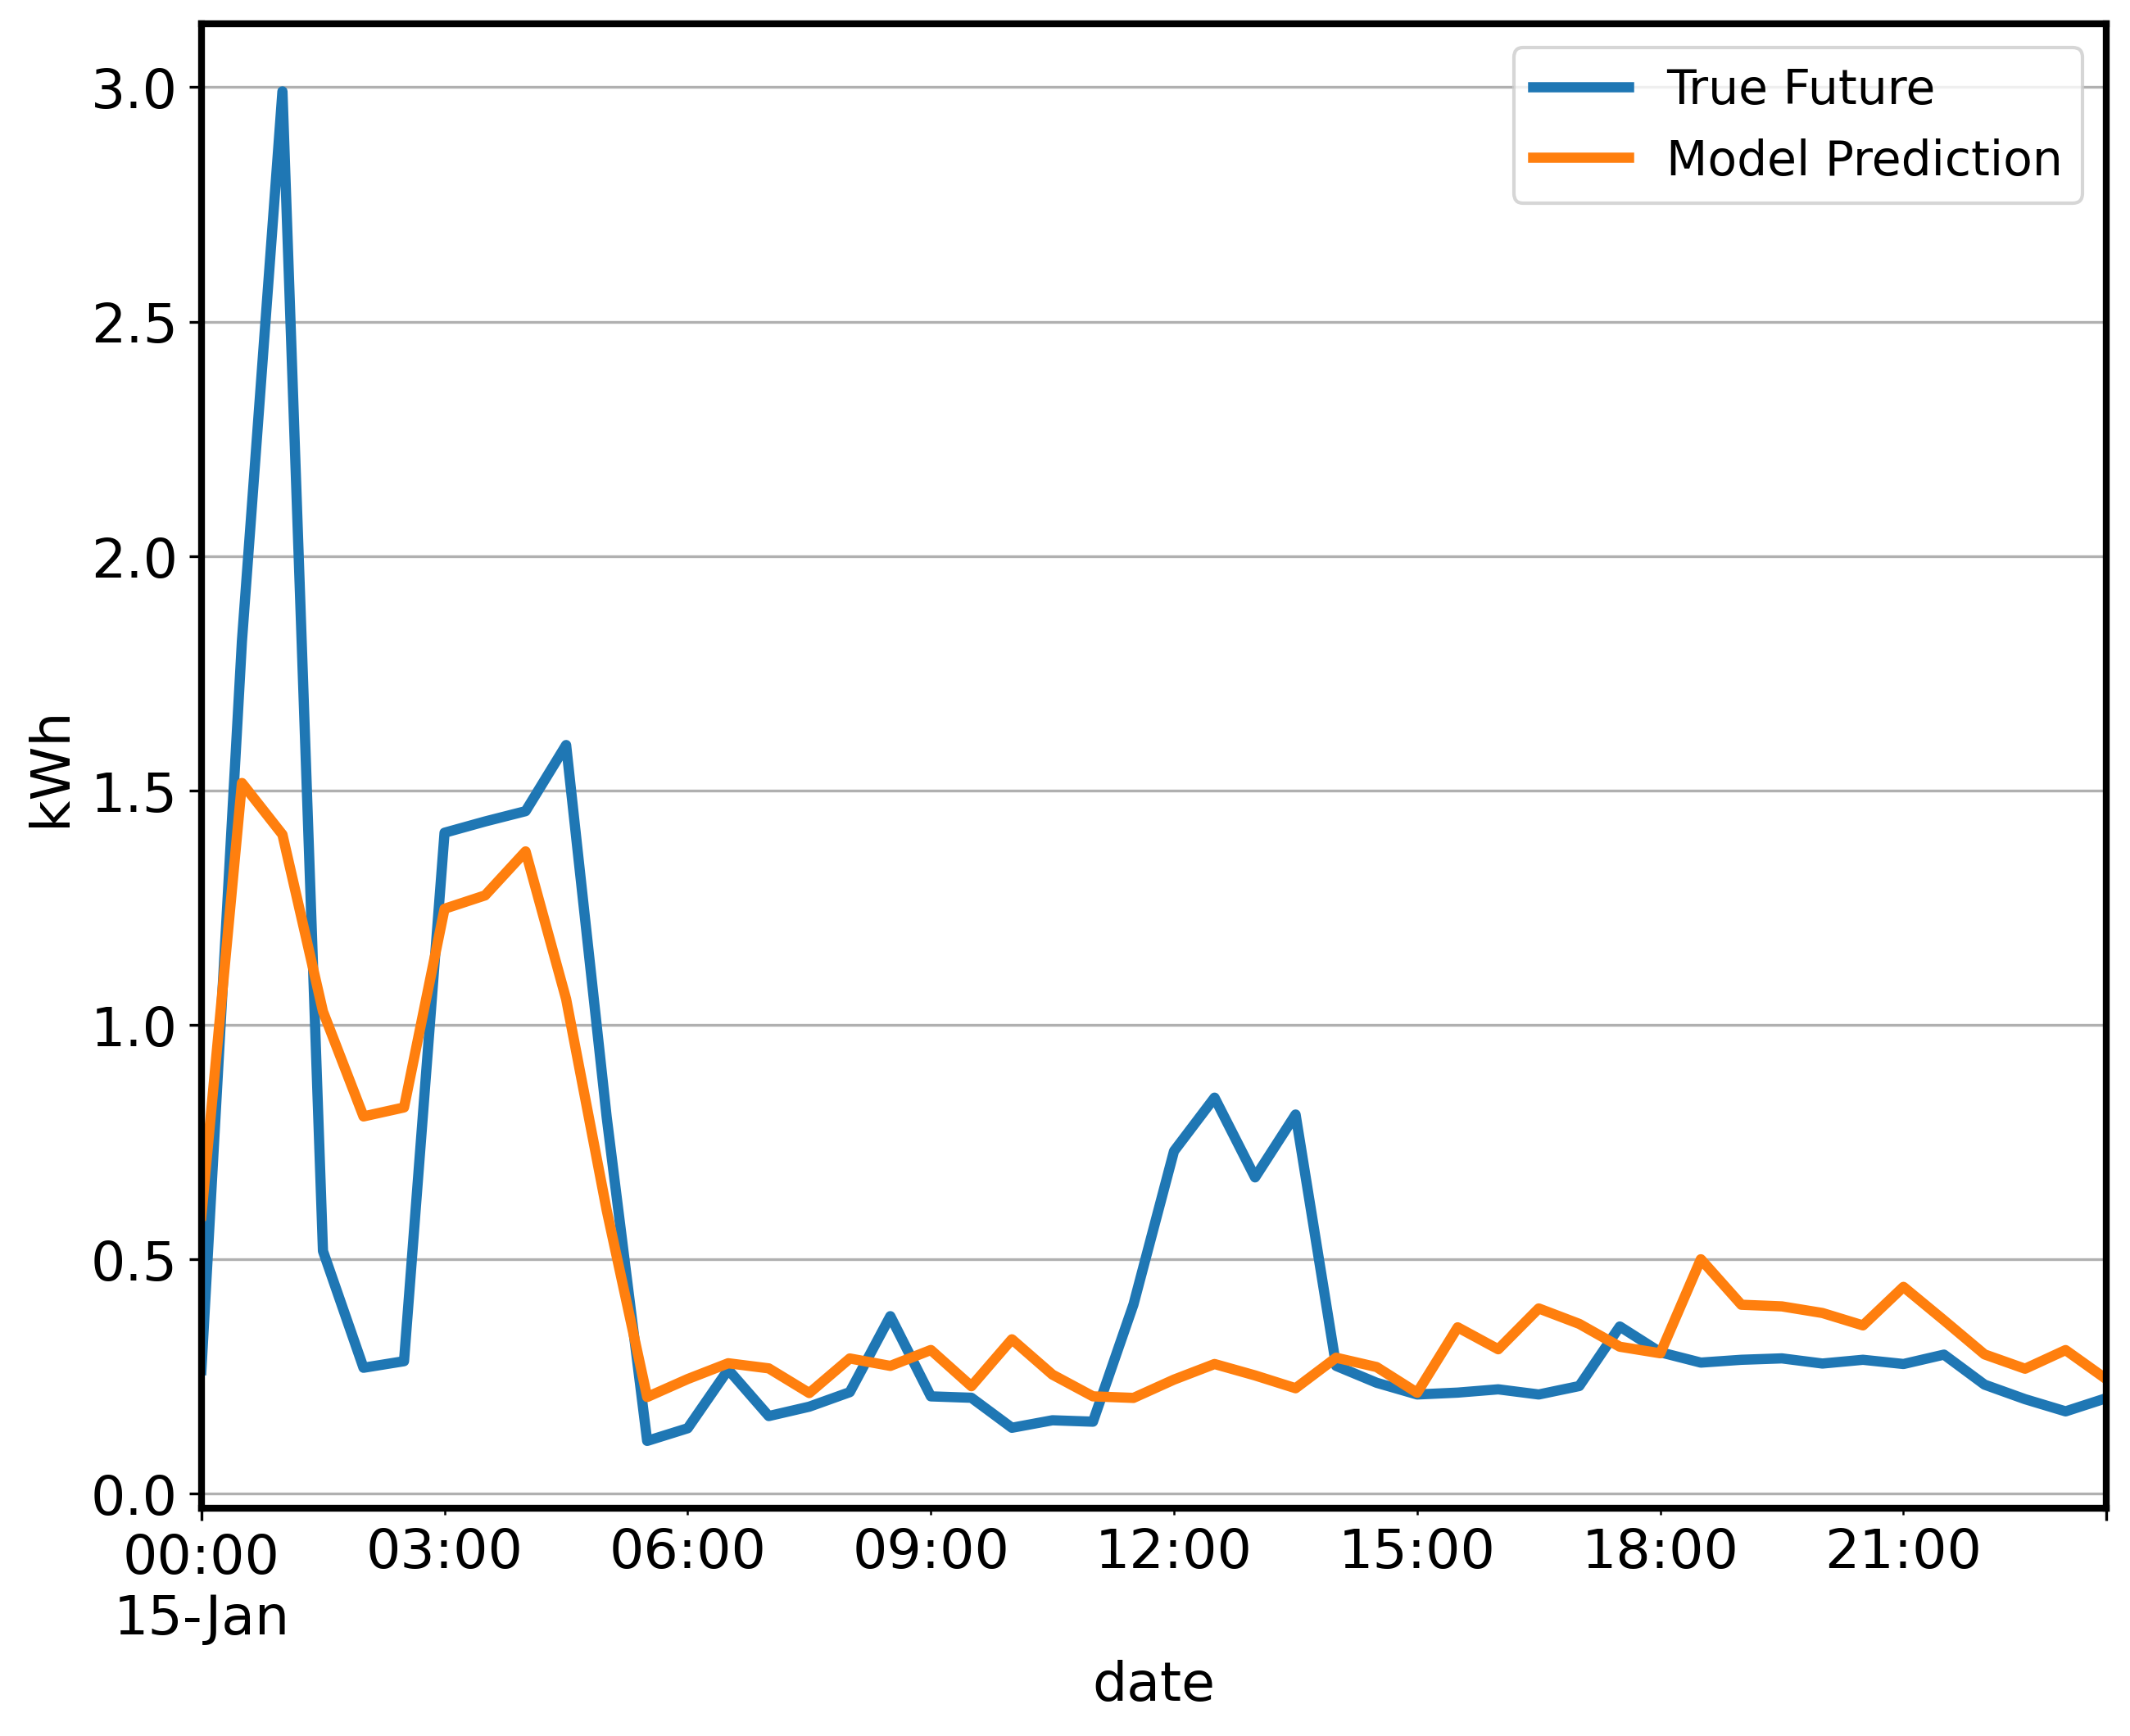

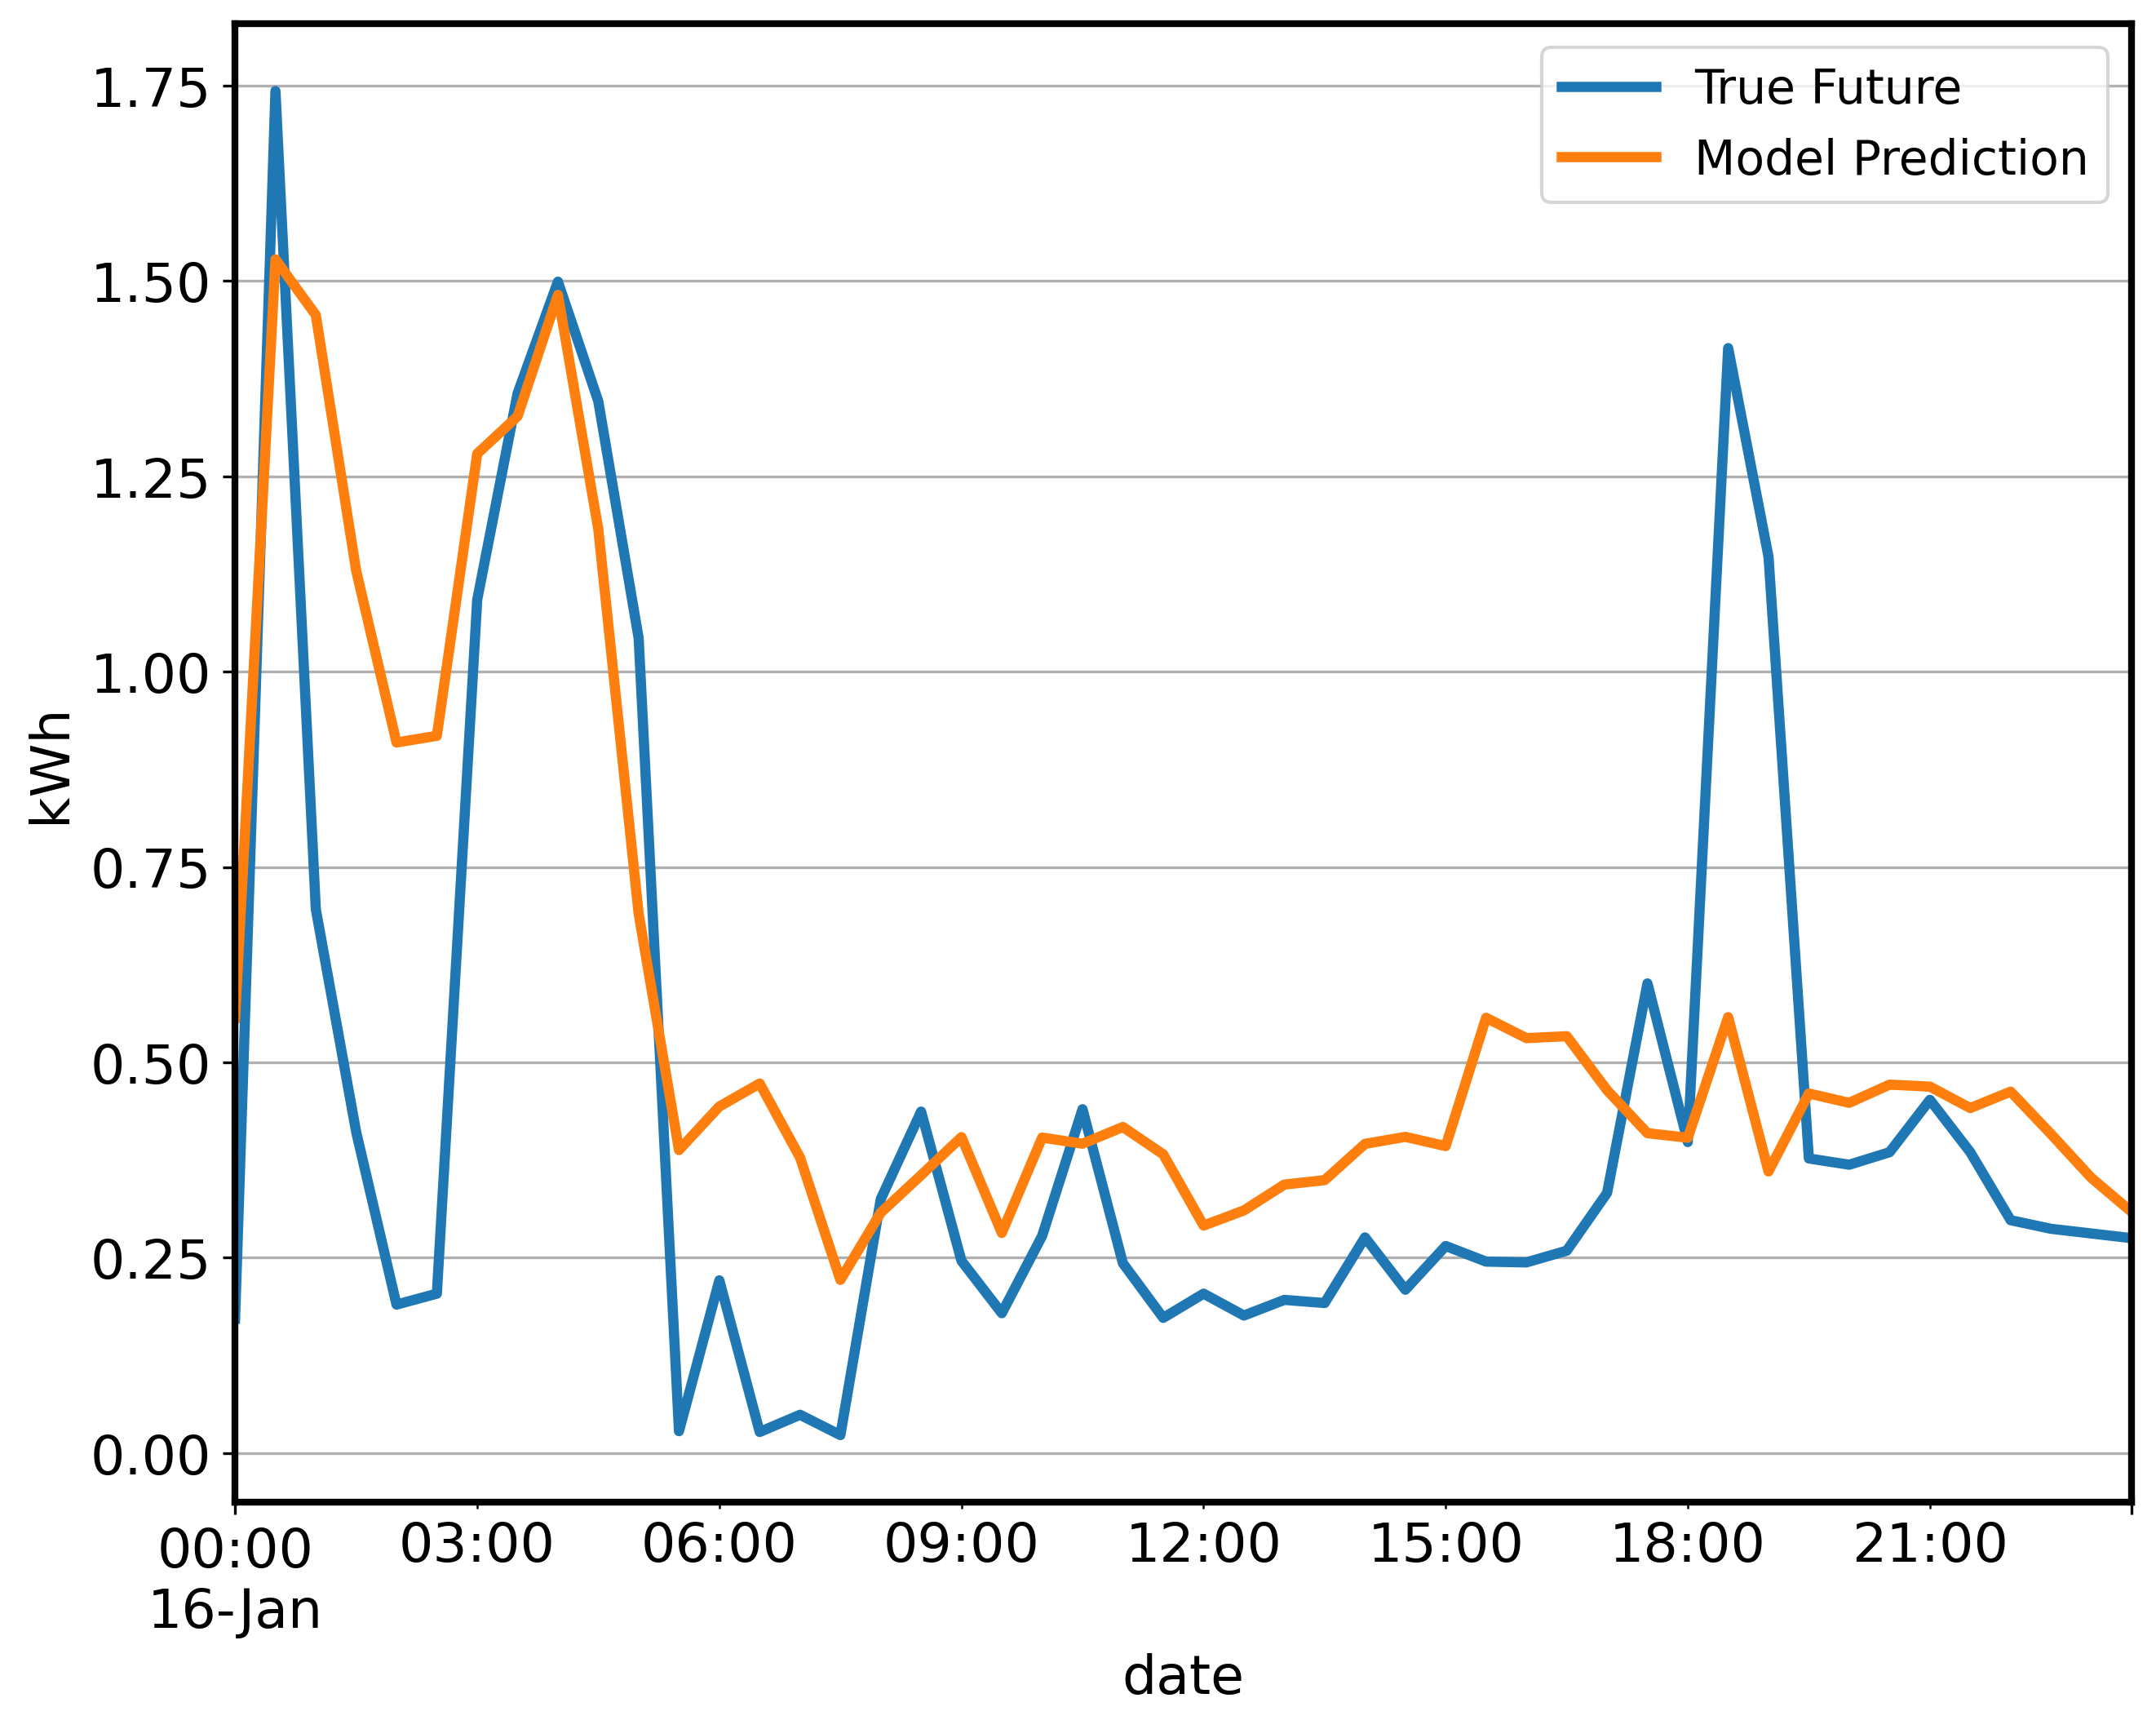

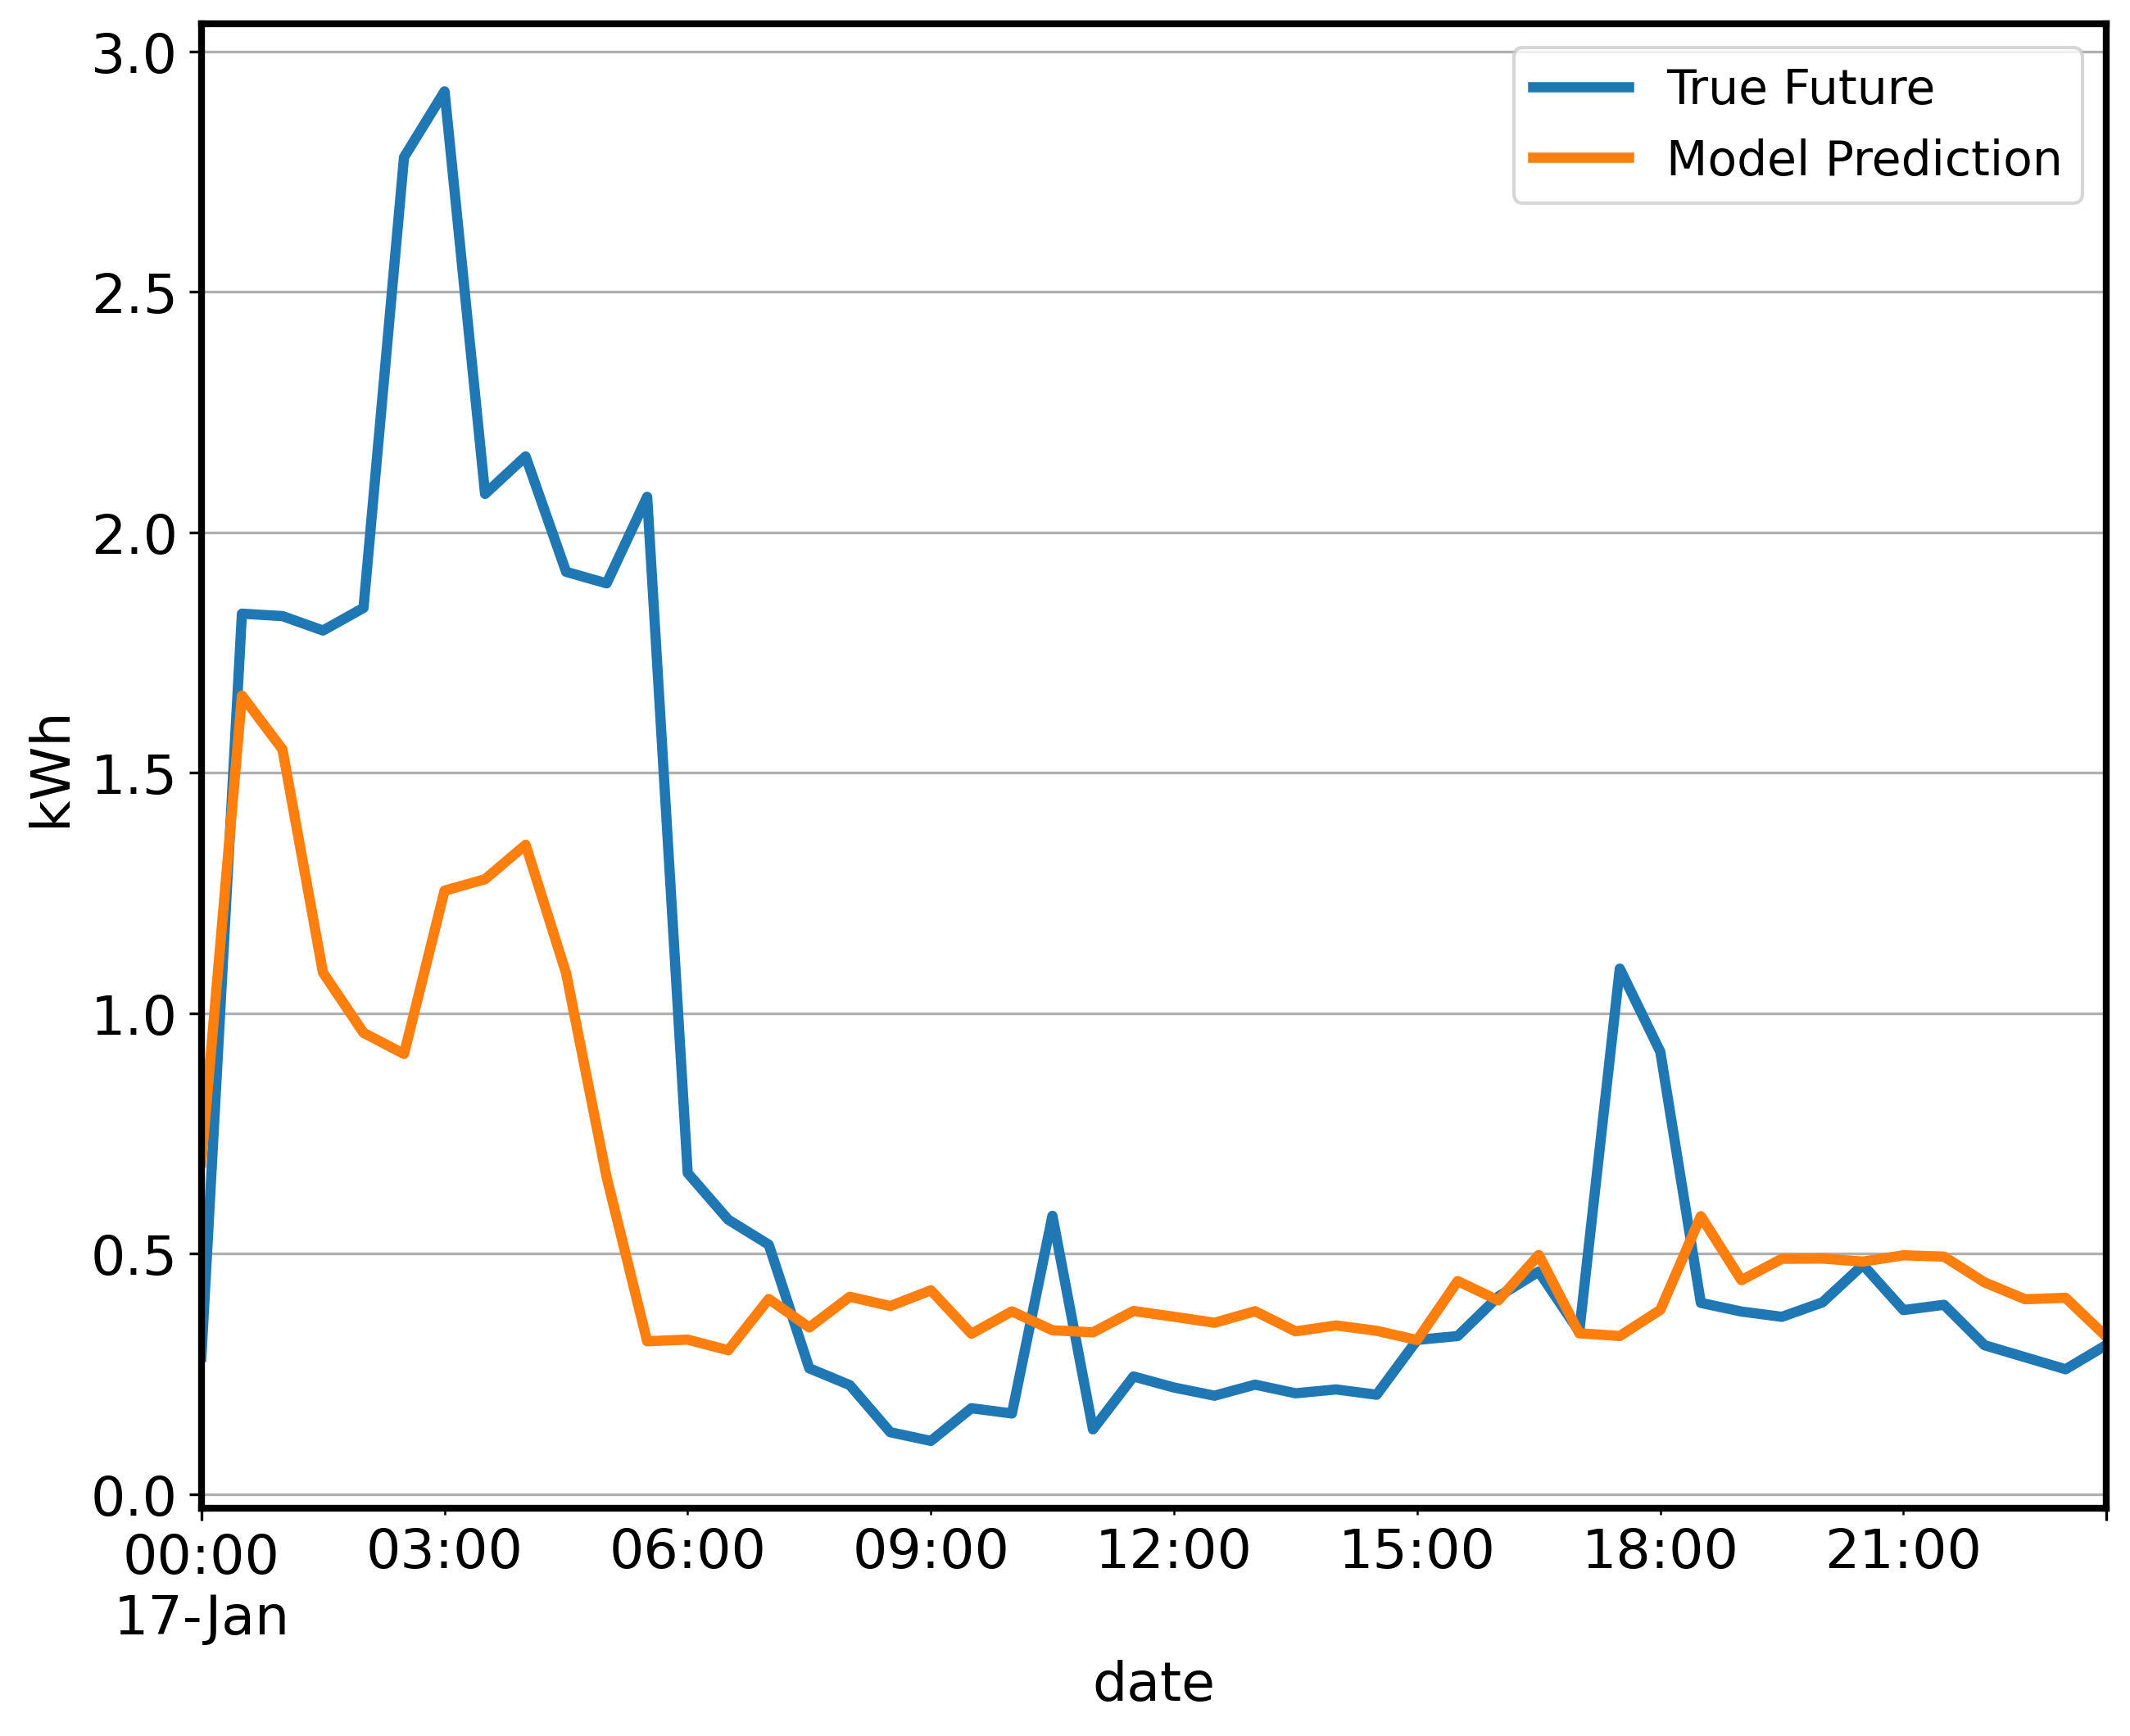

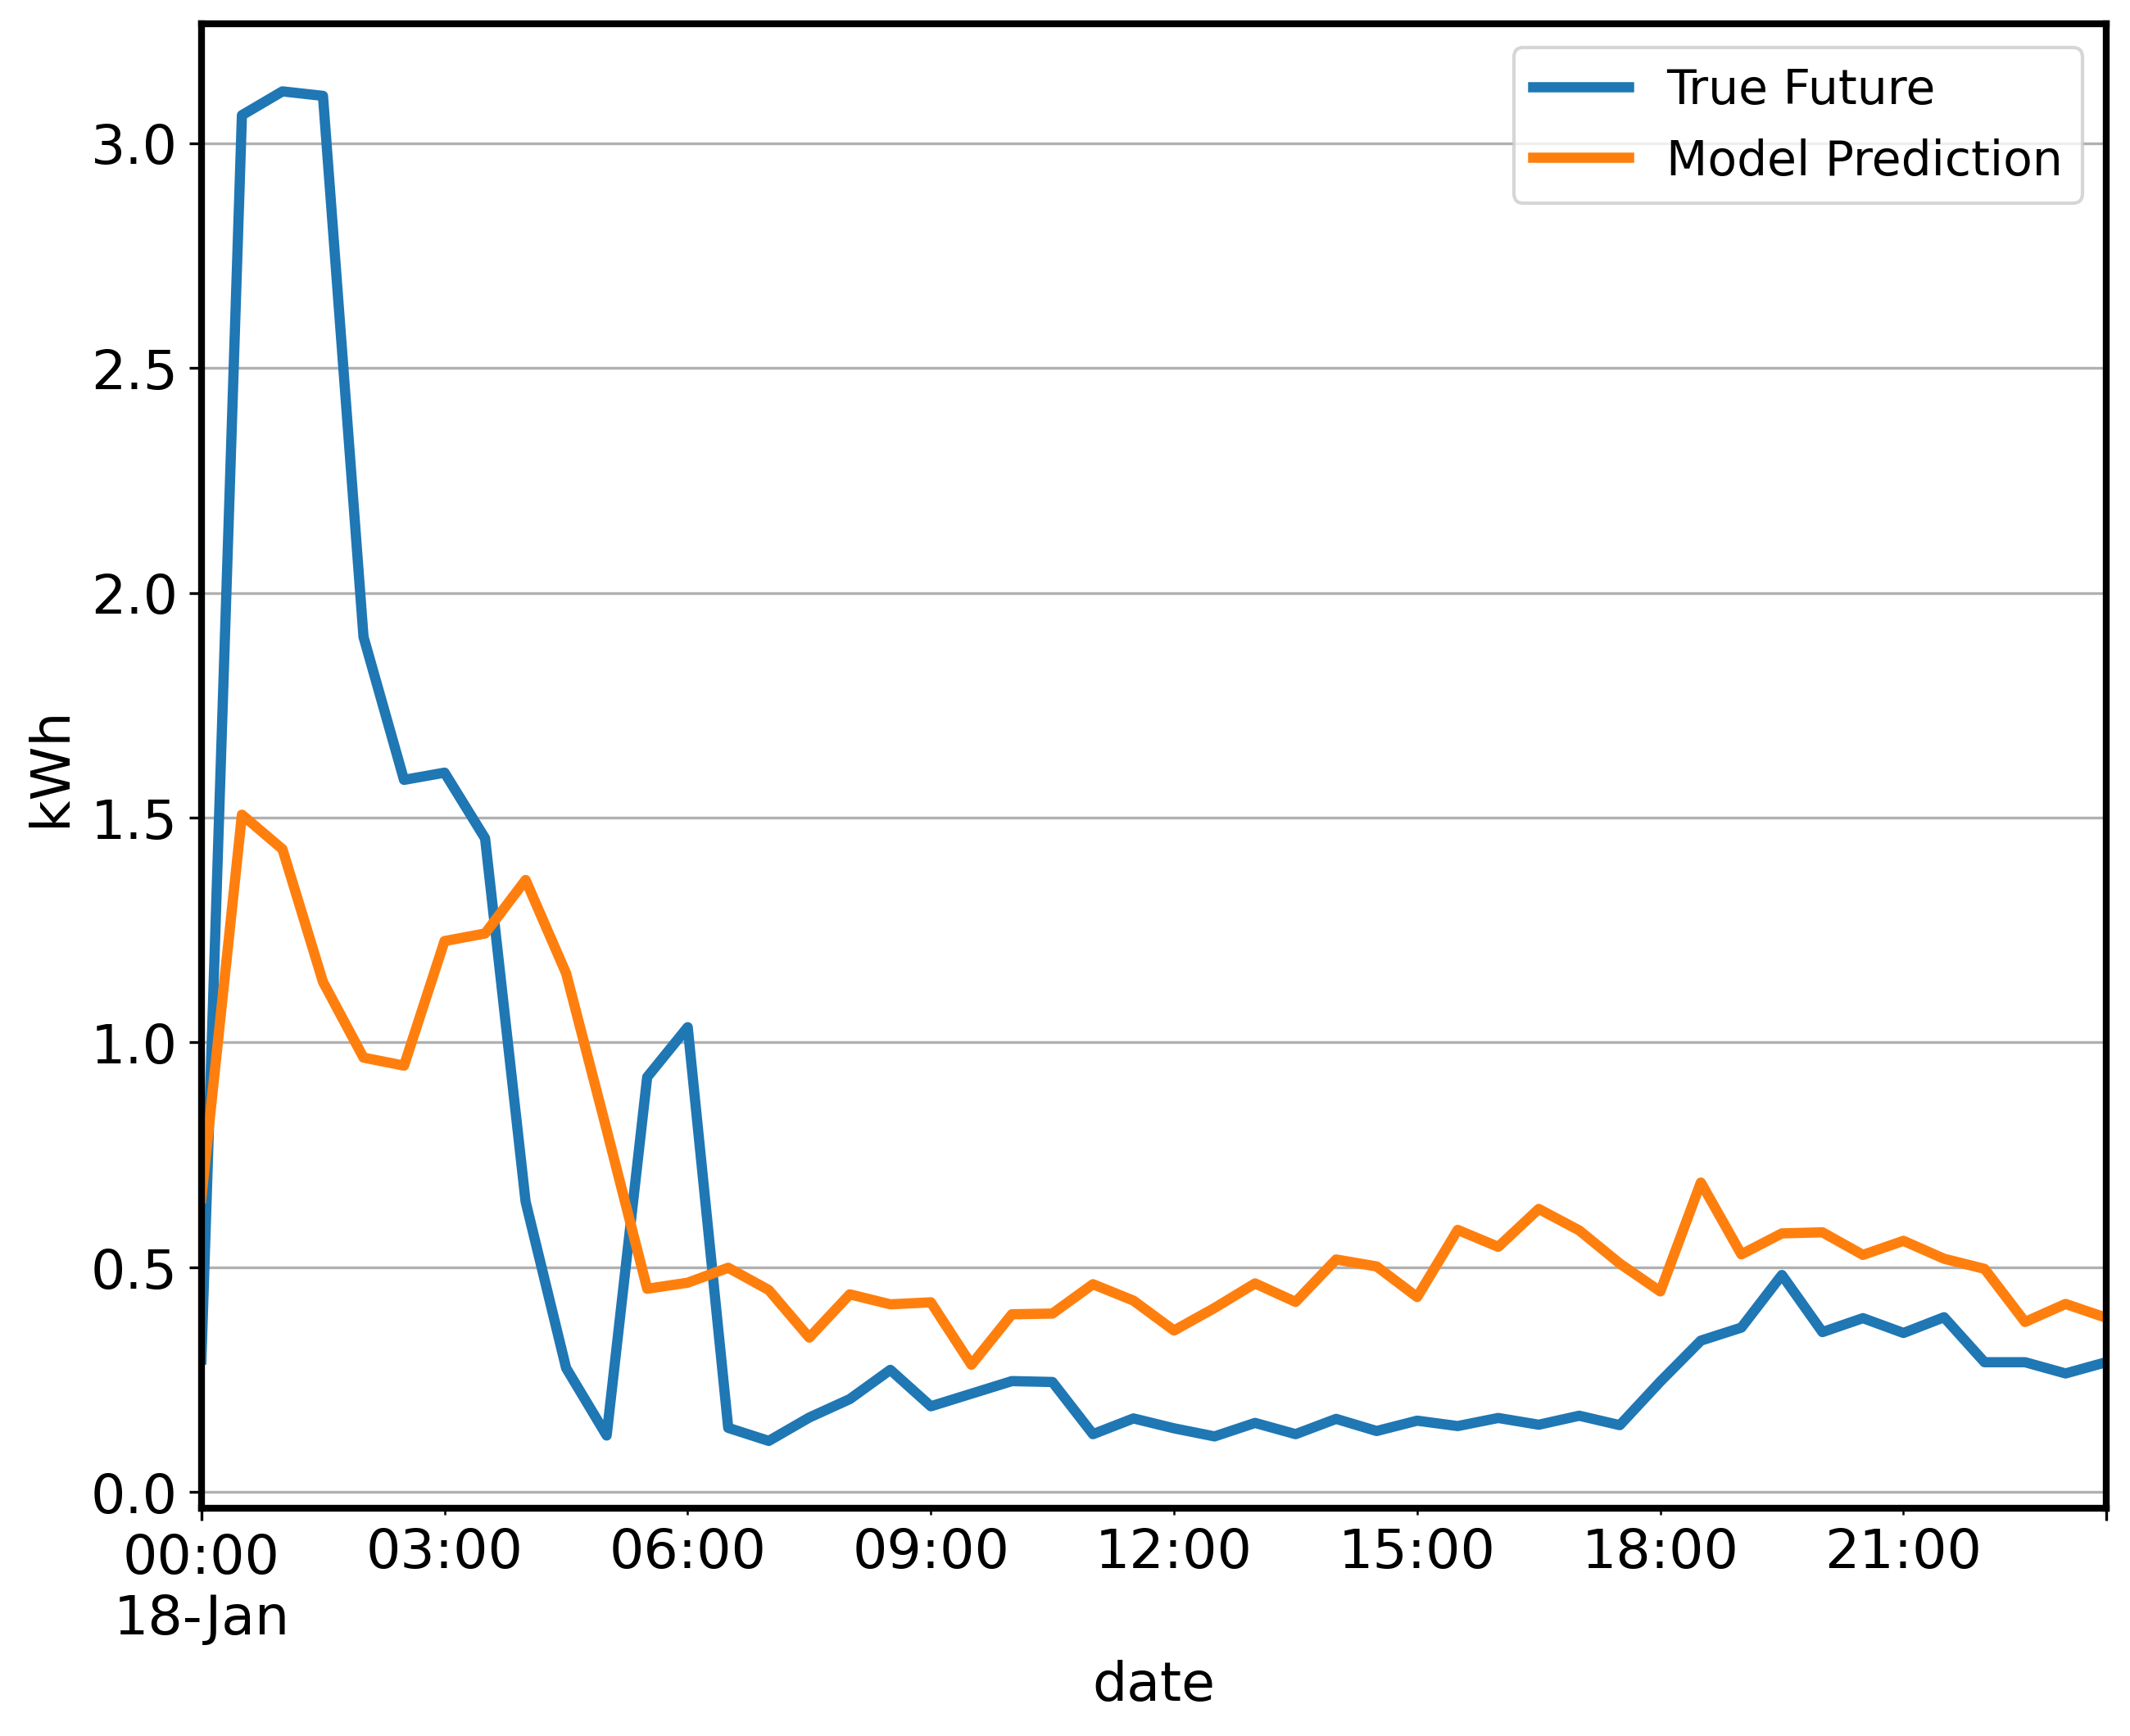

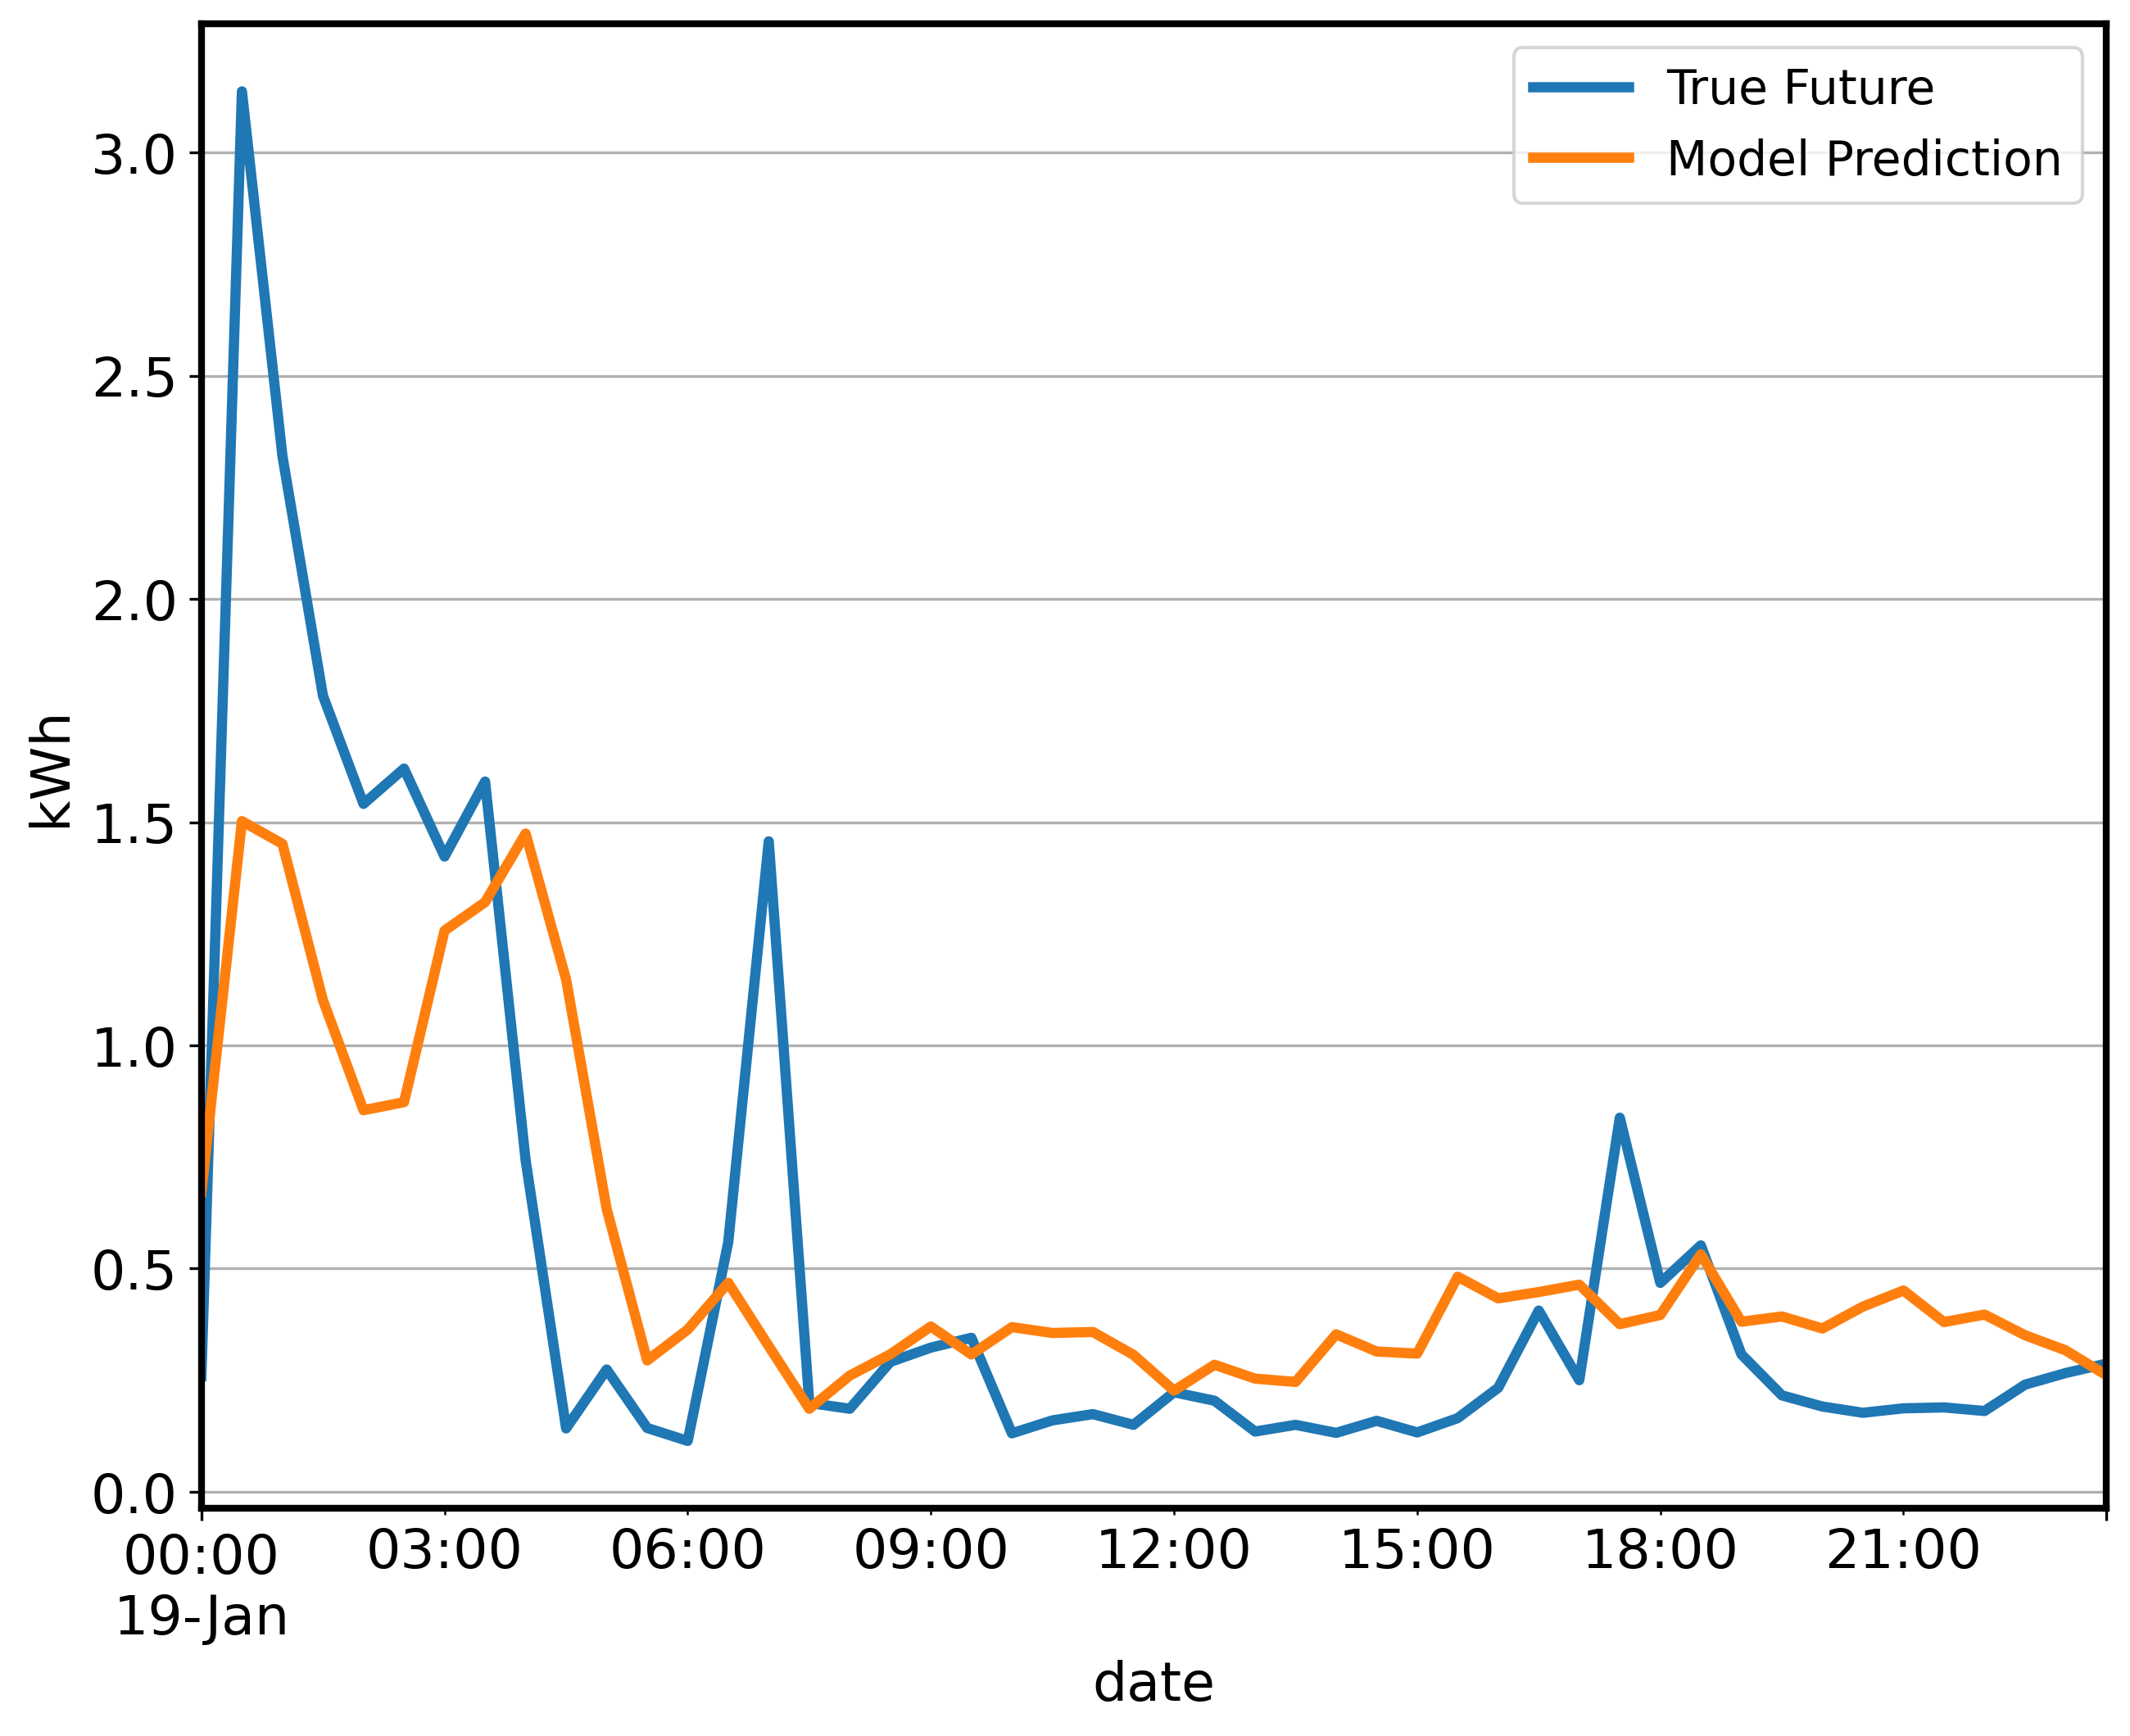

In [26]:
show_all_forecasts(all_predictions,all_references, time_serie1.name, True)

In [27]:
get_performance(all_predictions, all_references)


0.14858778441704207

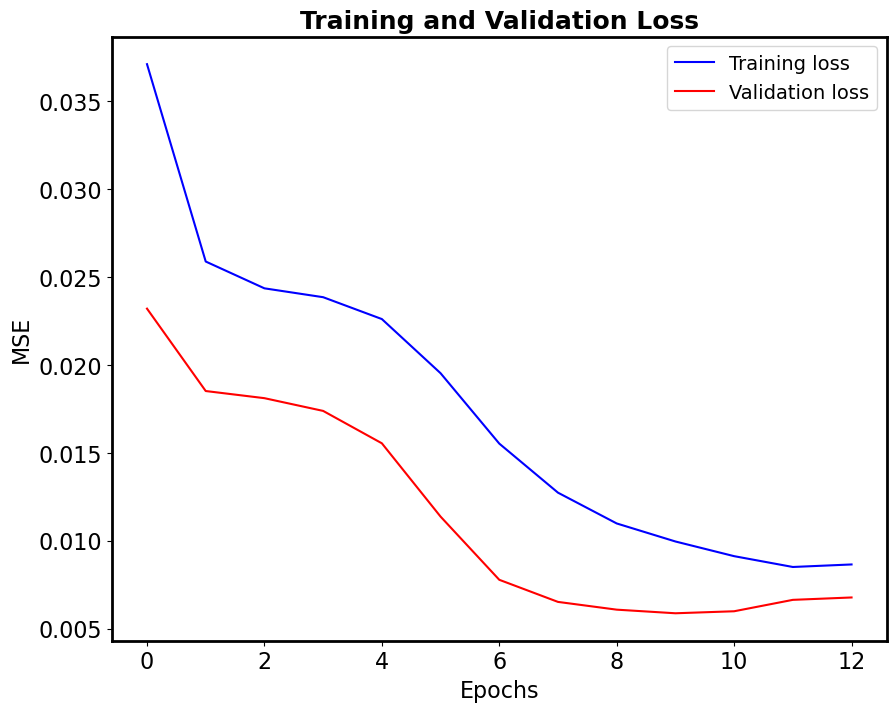

In [28]:
visualize_loss(history)

In [50]:
X[:,:,2]


array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [51]:
def repeated_performance(TS_norm_full: pd.Series, training: pd.Series, validation: pd.Series, test: pd.Series, temperature_norm: pd.Series, lag_value = 3, nb_epoch = 150, vb = 0, repeat = 2):
    collection = []
    for i in range(repeat):
        trained_model,hist = build_model_stateless1(training=training,validation=validation,temperature_norm=temperature_norm,lag_value=lag_value,nb_epoch=nb_epoch, verbose_para= vb)
        all_predictions, all_references = test_set_prediction(trained_model, TS_norm_full, temperature_norm, lag_value, test, True)
        p = get_performance(all_predictions, all_references)
        collection.append(p)
    return np.array(collection)
df = pd.DataFrame()
# df[TS.name] = repeated_performance(TS_norm_full, training, validation, test, temperature_norm, lag_value = 3, nb_epoch = 150, vb = 0, repeat = 2)



In [52]:
import time as t
results_file_name = str(t.time()) + ".txt"
results_file = open(results_file_name, "w")
results_file.write("This file displays the results of the hyperparameter search.")
results_file.close()


In [53]:
df = pd.DataFrame(data= np.arange(0,25,2))
df["1"] = np.zeros(13)
df.describe()

,0,1
count,13.000000,13.0
mean,12.000000,0.0
std,7.788881,0.0
min,0.000000,0.0
25%,6.000000,0.0
50%,12.000000,0.0
75%,18.000000,0.0
max,24.000000,0.0


<AxesSubplot:xlabel='date'>

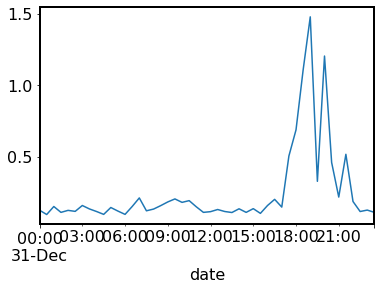

In [54]:
time_serie1.serie[-48:].plot()